# Review data

In [1]:
"""
Data process functions 
"""
import pandas as pd
import gzip
import json
import gc
import numpy as np


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


def item_limit(df, k):
    # tmp1 = df.groupby(['reviewerID'], as_index=False)['asin'].count()
    # tmp1.rename(columns={'asin': 'cnt_item'}, inplace=True)
    tmp2 = df.groupby(['asin'], as_index=False)['reviewerID'].count()
    tmp2.rename(columns={'reviewerID': 'cnt_user'}, inplace=True)
    
    df = df.merge(tmp2, on=['asin']) 
    query = "cnt_user >= %d" % (k)
    df = df.query(query).reset_index(drop=True).copy()
    df.drop(['cnt_user'], axis=1, inplace=True)
    del tmp2
    gc.collect()
    return df


def info(data):
    """ num of user, item, max/min uid/itemid, total interaction"""
    user = set(data['reviewerID'].tolist())
    item = set(data['asin'].tolist())
    print("number of user: ", len(user))
    print("max user ID: ", max(user))
    print("Min user ID: ", min(user))
    print("number of Item: ", len(item))
    print("Max item ID: ", max(item))
    print("Min item ID: ", min(item))
    print("Iteractions: ", len(data))

    
def user_limit(df, k=5):
    tmp1 = df.groupby(['reviewerID'], as_index=False)['asin'].count()
    tmp1.rename(columns={'asin': 'cnt_item'}, inplace=True)
    df = df.merge(tmp1, on=['reviewerID']) 
    query = "cnt_item >= %d" % (k)
    df = df.query(query).reset_index(drop=True).copy()
    df.drop(['cnt_item'], axis=1, inplace=True)
    del tmp1
    gc.collect()
    return df    

    
def category(dataf):
    dataf['reviewerID'] = pd.Categorical(dataf.uid).codes
    dataf['asin'] = pd.Categorical(dataf.asin).codes
    dataf.sort_values(['reviewerID', 'unixReviewTime'], inplace=True)
    return dataf


## Step 1: clear review data

### Book

In [4]:
filename = "/ceph/11329/ashexie/data/reviews_Books_5.json.gz"
out_dir = "/ceph/11329/chain/DHIN-CDR/datasets/amazon-book"
# get review data as dataframe\
df = getDF(filename)

In [5]:
# For rating prediction (reserve all rating data from 1-5 points)
# start_time = 631123200   # 1990, 1, 1, 0, 0, 0
start_time = 946656000   # 2000, 1, 1, 0, 0, 0
# filter out interaction before start time. 
df = df[df.unixReviewTime > start_time]  
# drop redandunt columns 
df = df.drop(['reviewerName', 'summary', 'helpful'], axis=1)

In [9]:
# k-core 
item_limit_num = 5
user_limit_num = 10
df = item_limit(df, k=item_limit_num)
df = user_limit(df, k=user_limit_num)

In [10]:
info(df)

number of user:  218106
max user ID:  AZZZT14MS21I6
Min user ID:  A000443821AD43TOGKNGZ
number of Item:  365641
Max item ID:  B00M13FNSS
Min item ID:  000100039X
Iteractions:  6427897


In [13]:
df.to_csv(f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-book/book-u{user_limit_num}-i{item_limit_num}.csv", index = False, header=True)

### Movie 

In [14]:
filename = "/ceph/11329/ashexie/data/reviews_Movies_and_TV_5.json.gz"
# get review data as dataframe 
df = getDF(filename)
start_time = 946656000   # 2000, 1, 1, 0, 0, 0
# filter out interaction before start time. 
df = df[df.unixReviewTime > start_time]  
# drop redandunt columns 
df = df.drop(['reviewerName', 'summary', 'helpful'], axis=1)
df = item_limit(df, k=item_limit_num)
df = user_limit(df, k=user_limit_num)
info(df)

number of user:  40593
max user ID:  AZZZMSZI9LKE6
Min user ID:  A0040548BPHKXMHH3NTI
number of Item:  49848
Max item ID:  B00LT1JHLW
Min item ID:  0005019281
Iteractions:  1168233


In [15]:
df.to_csv(f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-movie/movie-u{user_limit_num}-i{item_limit_num}.csv", index = False, header=True)

### CD 

In [16]:
filename = "/ceph/11329/ashexie/data/reviews_CDs_and_Vinyl_5.json.gz"
# get review data as dataframe 
df = getDF(filename)
start_time = 946656000   # 2000, 1, 1, 0, 0, 0
# filter out interaction before start time. 
df = df[df.unixReviewTime > start_time]  
# drop redandunt columns 
df = df.drop(['reviewerName', 'summary', 'helpful'], axis=1)
df = item_limit(df, k=item_limit_num)
df = user_limit(df, k=user_limit_num)
info(df)

number of user:  26193
max user ID:  AZZWPNME0GQZ2
Min user ID:  A02852361P0OLWYC4FW7X
number of Item:  63592
Max item ID:  B00L326LTI
Min item ID:  0307141985
Iteractions:  774591


In [17]:
df.to_csv(f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-cd/cd-u{user_limit_num}-i{item_limit_num}.csv", index = False, header=True)

## Step2: Find overlap users between domains 

In [18]:
def get_user_set(filename): 
    df = pd.read_csv(filename)
    return set(df['reviewerID'].tolist())

In [19]:
user_set_book = get_user_set(f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-book/book-u{user_limit_num}-i{item_limit_num}.csv")
user_set_movie = get_user_set(f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-movie/movie-u{user_limit_num}-i{item_limit_num}.csv")
user_set_cd = get_user_set(f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-cd/cd-u{user_limit_num}-i{item_limit_num}.csv")

In [20]:
print(len(user_set_book))
print(len(user_set_movie))
print(len(user_set_cd))

218106
40593
26193


In [21]:
# find out all users that has appeared at least in two domains. 
all_users_dict = {}

for user in list(user_set_book): 
    all_users_dict[user] = [1, 0, 0]

print(len(all_users_dict))
for user in list(user_set_movie): 
    if user not in all_users_dict:  
        all_users_dict[user] = [0, 1, 0]
    else:
        all_users_dict[user][1] = 1

print(len(all_users_dict))        
for user in list(user_set_cd): 
    if user not in all_users_dict: 
        all_users_dict[user] = [0, 0, 1]
    else:
        all_users_dict[user][2] = 1
print(len(all_users_dict))        

218106
247326
265095


### Book-movie 

In [22]:
user_book_movie = user_set_book.intersection(user_set_movie)
print(len(user_book_movie))

11373


### Book-CD

In [23]:
user_book_cd = user_set_book.intersection(user_set_cd)
print(len(user_book_cd))

4976


### Movie-CD

In [24]:
user_movie_cd = user_set_movie.intersection(user_set_cd)
print(len(user_movie_cd))

6262


# Single domain data 

## Step 3: Save overlapped UIDs

In [28]:
# select review data from both domain with the userID
import numpy as np


def user_selection_x(uid, file_a, file_b, outfile_a, outfile_b): 
    uid = pd.DataFrame(list(zip(list(uid), list(np.ones(len(uid))))), columns =['reviewerID', 'indicator'])
    df_a = pd.read_csv(file_a)
    print(len(set(df_a['reviewerID'])))
    df_b = pd.read_csv(file_b)
    print(len(uid['reviewerID']))
    # domain a 
    df_a = df_a.merge(uid, on='reviewerID', how='left')
    df_a = df_a.loc[df_a['indicator'] == 1]
    df_a.drop(['indicator'], axis=1, inplace=True)
    print(len(set(df_a['reviewerID'])))
    # domain b 
    df_b = df_b.merge(uid, on='reviewerID', how='left')
    df_b = df_b.loc[df_b['indicator'] == 1]
    df_b.drop(['indicator'], axis=1, inplace=True)
    print(len(set(df_b['reviewerID'])))
    # save 
    df_a.to_csv(outfile_a, index = False, header=True)
    df_b.to_csv(outfile_b, index = False, header=True)
    

### book-movie

In [30]:
file_a = f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-book/book-u{user_limit_num}-i{item_limit_num}.csv"
file_b = f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-movie/movie-u{user_limit_num}-i{item_limit_num}.csv"
outfile_a = "/ceph/11329/chain/DHIN-CDR/datasets/book-movie/book_rate.csv"
outfile_b = "/ceph/11329/chain/DHIN-CDR/datasets/book-movie/movie_rate.csv"

user_selection_x(user_book_movie, file_a, file_b, outfile_a, outfile_b)

218106
11373
11373
11373


### book-cd

In [31]:
file_a = f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-book/book-u{user_limit_num}-i{item_limit_num}.csv"
file_b = f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-cd/cd-u{user_limit_num}-i{item_limit_num}.csv"
outfile_a = "/ceph/11329/chain/DHIN-CDR/datasets/book-cd/book_rate.csv"
outfile_b = "/ceph/11329/chain/DHIN-CDR/datasets/book-cd/cd_rate.csv"

user_selection_x(user_book_cd, file_a, file_b, outfile_a, outfile_b)

218106
4976
4976
4976


### movie-cd

In [32]:
file_a = f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-movie/movie-u{user_limit_num}-i{item_limit_num}.csv"
file_b = f"/ceph/11329/chain/DHIN-CDR/datasets/amazon-cd/cd-u{user_limit_num}-i{item_limit_num}.csv"
outfile_a = "/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_rate.csv"
outfile_b = "/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_rate.csv"

user_selection_x(user_movie_cd, file_a, file_b, outfile_a, outfile_b)

40593
6262
6262
6262


# Item Raw

In [33]:
def get_item_set(filename): 
    df = pd.read_csv(filename)
    return set(df['asin'].tolist())

def item_selection_x(item_raw, sel_item): 
    item_id = pd.DataFrame(list(zip(list(sel_item), list(np.ones(len(sel_item))))), columns =['asin', 'indicator'])
    # domain a 
    item_raw = item_raw.merge(item_id, on='asin', how='left')
    item_raw = item_raw.loc[item_raw['indicator'] == 1]
    item_raw.drop(['indicator'], axis=1, inplace=True)
    print(len(set(item_raw['asin'])))
    
    return item_raw

In [34]:
raw_movie = getDF("/ceph/11329/ashexie/data/ft_local/meta_Movies_and_TV.json.gz")
raw_cd = getDF("/ceph/11329/ashexie/data/ft_local/meta_CDs_and_Vinyl.json.gz")
raw_book = getDF("/ceph/11329/ashexie/data/ft_local/meta_Books.json.gz")

In [35]:
raw_cd.drop(['tech1', "feature", 'fit', "similar_item", 'tech2', 'also_view', 'also_buy', 'date' ,'imageURL','imageURLHighRes', 'details'], axis=1, inplace=True)
raw_book.drop(['tech1', "feature", 'fit', "similar_item", 'tech2', 'also_view', 'also_buy', 'date' ,'imageURL','imageURLHighRes', 'details'], axis=1, inplace=True)
raw_movie.drop(['tech1', "feature", 'fit', 'tech2', "similar_item", 'also_view', 'also_buy', 'date' ,'imageURL','imageURLHighRes', 'details'], axis=1, inplace=True)

In [61]:
# raw_cd.drop(["feature", "similar_item"], axis=1, inplace=True)
# raw_book.drop(["feature", "similar_item"], axis=1, inplace=True)
# raw_movie.drop(["feature", "similar_item"], axis=1, inplace=True)

## movie-cd

In [36]:
sel_movie_ids = get_item_set("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_rate.csv")
sel_cd_ids = get_item_set("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_rate.csv")

# movie raw 
sel_movie_raw = item_selection_x(raw_movie, sel_movie_ids)

# cd raw 
sel_cd_raw = item_selection_x(raw_cd, sel_cd_ids)
# 26821
# 34295

23165
35396


In [37]:
# save to file 
sel_movie_raw.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_feat.csv', index = False, header=True)
sel_cd_raw.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_feat.csv', index = False, header=True)

## book-moive

In [38]:
sel_book_ids = get_item_set("/ceph/11329/chain/DHIN-CDR/datasets/book-movie/book_rate.csv")
sel_movie_ids = get_item_set("/ceph/11329/chain/DHIN-CDR/datasets/book-movie/movie_rate.csv")

# book raw 
sel_book_raw = item_selection_x(raw_book, sel_book_ids)
# movie raw 
sel_movie_raw = item_selection_x(raw_movie, sel_movie_ids)

# save to file
sel_movie_raw.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/book-movie/movie_feat.csv', index = False, header=True)
sel_book_raw.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/book-movie/book_feat.csv', index = False, header=True)

152087
25507


## book-cd

In [39]:
sel_book_ids = get_item_set("/ceph/11329/chain/DHIN-CDR/datasets/book-cd/book_rate.csv")
sel_cd_ids = get_item_set("/ceph/11329/chain/DHIN-CDR/datasets/book-cd/cd_rate.csv")

# book raw 
sel_book_raw = item_selection_x(raw_book, sel_book_ids)
# movie raw 
sel_cd_raw = item_selection_x(raw_cd, sel_cd_ids)

# save to file
sel_cd_raw.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/book-cd/cd_feat.csv', index = False, header=True)
sel_book_raw.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/book-cd/book_feat.csv', index = False, header=True)

100460
33447


In [29]:
cd_feat = pd.read_csv('/ceph/11329/chain/DHIN-CDR/datasets/book-cd/cd_feat.csv')
cd_feat

,category,description,title,brand,rank,main_cat,price,asin
0,"['CDs & Vinyl', 'Classic Rock', 'British Invas...","['""Hullabaloo"" featured the most popular rock ...","Hullabaloo, Vols. 1-4",Patrick Adiarte,"141,587 in Movies & TV (",Movies & TV,NaN,0788602144
1,"['CDs & Vinyl', 'Comedy & Spoken Word', 'Spoke...",['Guided meditation to train your mind to quie...,Goodbye Worries,Roberta Shapiro,"6,934 in CDs & Vinyl (","<img src=""https://images-na.ssl-images-amazon....",$10.99,1450734618
2,"['CDs & Vinyl', 'Comedy & Spoken Word', 'Poetry']",['Captured live at the Wax Museum Nightclub in...,Black Wax &amp; Is That Jazz VHS,Gil Scott-Heron,"404,594 in Movies & TV (",Movies & TV,$6.99,1572524030
3,"['CDs & Vinyl', 'World Music', 'Europe', 'Brit...","['OZZY, OUTRAGEOUS AS EVER, PERFORMS WAR PIGS,...",Ozzy Osbourne - Live &amp; Loud,NaN,"33,048 in Movies & TV (",Movies & TV,$9.99,1573300411
4,"['CDs & Vinyl', 'Pop', 'Oldies', 'Traditional ...","['INCLUDES FLY ME TO THE MOON, STEPPING OUT WI...",Tony Bennett - MTV Unplugged: The Video,NaN,"90,260 in Movies & TV (",Movies & TV,$9.44,1573306894
...,...,...,...,...,...,...,...,...
43029,"['CDs & Vinyl', 'Soundtracks', 'Movie Scores']",[],Think Like a Man Too Music from and Inspired b...,Mary J. Blige,"158,662 in CDs & Vinyl (","<img src=""https://images-na.ssl-images-amazon....",$3.00,B00KINIPI8
43030,"['CDs & Vinyl', 'Dance & Electronic', 'Electro...","[""Within weeks of the release of their acclaim...",High Life,Eno & Hyde,"64,748 in CDs & Vinyl (","<img src=""https://images-na.ssl-images-amazon....",$15.98,B00KLSSKA8
43031,"['CDs & Vinyl', 'Pop']","[""2 CD Set featuring over 2 hours of previousl...","GarciaLive Volume Four: March 22nd, 1978 Veter...",Jerry Garcia,"14,571 in CDs & Vinyl (","<img src=""https://images-na.ssl-images-amazon....",$14.10,B00KPHL7K0
43032,"['CDs & Vinyl', 'Pop']",['Brand new album from Grammy nominated soul s...,Paula,Robin Thicke,"129,773 in CDs & Vinyl (","<img src=""https://images-na.ssl-images-amazon....",$11.99,B00KTS9ZFY


# ReID and statistics

In [19]:
pip install matplotlib 

Looking in indexes: https://mirrors.cloud.tencent.com/pypi/simple/, http://mirrors.oa.com/pypi/web/simple/
     |████████████████████████████████| 9.4 MB 554 kB/s eta 0:00:01     |████▍                           | 1.3 MB 1.3 MB/s eta 0:00:07
     |████████████████████████████████| 1.2 MB 468 kB/s eta 0:00:01
     |████████████████████████████████| 965 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 1.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd 
import matplotlib.pyplot as plt 


def second2day(x):
    return x/(60*60*24)


def df2Seq(filename): 
    test_df = pd.read_csv(filename)
    test_df.sort_values(by=['unixReviewTime'], inplace=True)
    test_df['unixReviewTime'] = test_df['unixReviewTime'].map(second2day)
    test_df.drop(columns=['reviewText', "reviewTime"], inplace=True)
    seq_user = test_df.groupby(by='reviewerID').agg(lambda x: list(x))
    seq_item = test_df.groupby(by='asin').agg(lambda x: list(x))
    return seq_user, seq_item  


In [17]:
def get_statistics(filename): 
    df = pd.read_csv(filename)
    
    # number of users and items 
    n_user = len(set(df['reviewerID']))
    n_item = len(set(df['asin']))
    n_inter = len(df)
    print(f"n_user: {n_user}\n n_item: {n_item} \n interaction: {n_inter}\n sparsity: {1 - n_inter/ (n_user * n_item)}")
    print(f"average sequence length: {n_inter / n_user} ")
    
#     # user and item info 
    df_user = df.groupby(by='reviewerID')['asin'].count().reset_index(name='count')
    df_item = df.groupby(by='asin')['reviewerID'].count().reset_index(name='count')
    
    # rating scores 
    scores = df['overall'].tolist()
    plt.hist(scores)
    plt.show()
    
    return df_user, df_item



## Movie-CD

n_user: 6262
 n_item: 58492 
 interaction: 320464
 sparsity: 0.9991250772393774
average sequence length: 51.175982114340464 


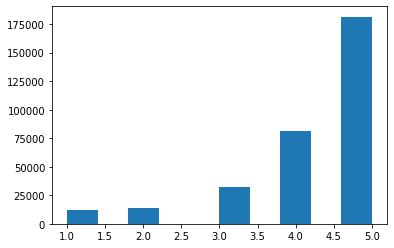

In [60]:
# convert to user seq format 
# 1. order by time
# 2. group by user 
user_pop, item_pop = get_statistics("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_rate.csv")
user_seq, item_seq = df2Seq("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_rate.csv")

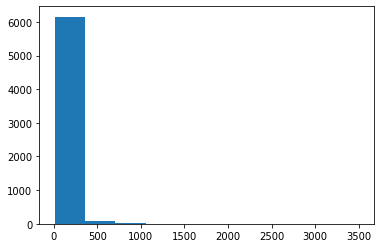

In [52]:
# plot 
plt.hist(user_pop['count'].tolist())
plt.show()

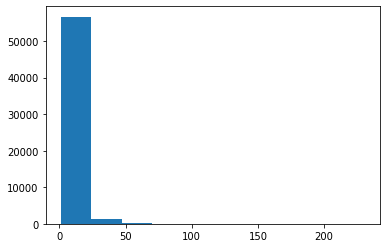

In [53]:
plt.hist(item_pop['count'].tolist())
plt.show()

In [54]:
print(min(user_pop['count'].tolist()), max(user_pop['count'].tolist()))

10 3501


In [62]:
user_seq.to_csv("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq.csv")
item_seq.to_csv("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_item_seq.csv")

In [61]:
user_seq

,asin,overall,unixReviewTime
reviewerID,,,
A0644664269UTSPKMVCVH,"[B000009HQW, B000003G7W, B0000BZNDK, B00004Z45...","[4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[15850.0, 15850.0, 15853.0, 15881.0, 15897.0, ..."
A08161909WK3HU7UYTMW,"[B008EOQVCK, B00005OMGE, B008RMFJQS, B0041WLBE...","[5.0, 4.0, 2.0, 4.0, 3.0, 5.0, 5.0, 5.0, 5.0, ...","[15703.0, 15703.0, 15703.0, 15703.0, 15723.0, ..."
A1006V961PBMKA,"[B00000JSBD, B000065BW8, B000003TAW, B00005KH2...","[2.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 2.0, 5.0, ...","[11717.0, 12055.0, 12055.0, 12135.0, 12136.0, ..."
A100JCBNALJFAW,"[B00005A7WX, B0001NBMBC, B00000099X, B0007WF1X...","[1.0, 4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 4.0, ...","[12557.0, 12576.0, 13091.0, 13097.0, 13102.0, ..."
A101L4HF0IZ33C,"[B003O5MNB2, B00000DHTF, B008LZHA3G, B0041CGOZ...","[2.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 3.0, 5.0, ...","[15405.0, 15440.0, 15619.0, 15718.0, 15718.0, ..."
...,...,...,...
AZWIW0T8UFBU1,"[B000001E71, B000050I5F, B000000WFZ, B00064AF1...","[5.0, 4.0, 2.0, 3.0, 4.0, 2.0, 5.0, 4.0, 2.0, ...","[11997.0, 12774.0, 12788.0, 13019.0, 13343.0, ..."
AZXHK8IO25FL6,"[B0002IQ9SW, B0000C1732, B00009PY1H, B00006JJ3...","[5.0, 1.0, 1.0, 2.0, 4.0, 5.0, 5.0, 5.0, 1.0, ...","[12614.0, 12614.0, 12615.0, 12615.0, 12615.0, ..."
AZXP46IB63PU8,"[B00076YOPY, B000G03RJA, B00BPWDMP2, B0000058H...","[5.0, 5.0, 4.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[16104.0, 16121.0, 16121.0, 16121.0, 16121.0, ..."


In [63]:
item_seq 

,reviewerID,overall,unixReviewTime
asin,,,
0307141985,"[A6GMEO3VRY51S, A3E102F6LPUF1J, A2JP0URFHXP6DO...","[5.0, 5.0, 5.0, 4.0]","[12247.0, 12362.0, 13208.0, 15301.0]"
073890015X,"[A24E0F4QEQ4VXM, A3QAV7LALVG1F7, A2KCJ6AACY6J0...","[3.0, 5.0, 3.0, 5.0, 5.0]","[11283.0, 12075.0, 13197.0, 13756.0, 15959.0]"
0738900370,"[A3SAU1A0IEYDNX, A3S5C7Y0WT2Q9N, A39S9XEW3ESL1...","[5.0, 3.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...","[11221.0, 12049.0, 12329.0, 12504.0, 12558.0, ..."
0738900672,"[A3F4V1W3IINU19, A97B72F4UI8FA, A1OB5L3WMHJAD9...","[5.0, 5.0, 3.0, 5.0, 4.0]","[11313.0, 11734.0, 11995.0, 12794.0, 13783.0]"
0738919039,"[A23DFB8IUTIZM0, A2CN3U4JCMSMA, AUX9KZUUB3YCE,...","[5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 2.0, 5.0, 3.0, ...","[11236.0, 11626.0, 11848.0, 12059.0, 12198.0, ..."
...,...,...,...
B00KINIPI8,"[A3HU0B9XUEVHIM, A9Q28YTLYREO7, A1HCCW38EQQBTY]","[4.0, 2.0, 5.0]","[16238.0, 16252.0, 16254.0]"
B00KLSSKA8,[A20S7XV2JK0UXL],[4.0],[16273.0]
B00KPHL7K0,"[A17MBLP80LHTED, A3BK1TF3W0867C]","[5.0, 5.0]","[16267.0, 16272.0]"


### Movie

n_user: 6262
 n_item: 43439 
 interaction: 374758
 sparsity: 0.998622289303159
average sequence length: 59.84637496007665 


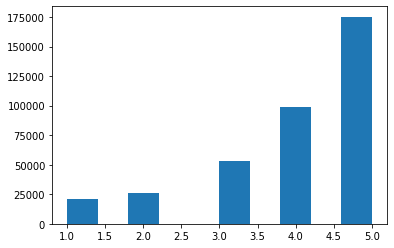

In [21]:
user_pop, item_pop = get_statistics("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_rate.csv")
user_seq, item_seq = df2Seq("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_rate.csv")
user_seq.to_csv("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_user_seq.csv")
item_seq.to_csv("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_item_seq.csv")


## book-movie

## book-cd

# Step 4, IDdict and data split  

In [10]:
def train_valid_test(filename): 
    test_df = pd.read_csv(filename)
    data_train = {'uid': [], "item_seq": [], "time_seq": [], "rate": []}   # key: user_ID
    data_valid = {'uid': [], "item_seq": [], "time_seq": [], "rate": []}
    data_test = {'uid': [], "item_seq": [], "time_seq": [], "rate": []}
    
    for index, row in test_df.iterrows():
        uid = row['reviewerID']
        item_seq = eval(row['asin'])
        time_seq = eval(row['unixReviewTime'])
        ratings = eval(row['overall'])
        
        # split time? 
        seq_len = len(item_seq)
        # train_num = int(seq_len * 0.6) 
        train_num = seq_len - 4 
        valid_num = 2
        
        item_seq_train = item_seq[0:train_num]
        item_seq_valid = item_seq[train_num:train_num + valid_num]
        item_seq_test = item_seq[train_num + valid_num:]
        
        time_seq_train = time_seq[0:train_num]
        time_seq_valid = time_seq[train_num:train_num + valid_num]
        time_seq_test = time_seq[train_num + valid_num:]
        
        rate_seq_train = ratings[0:train_num]
        rate_seq_valid = ratings[train_num:train_num + valid_num]
        rate_seq_test = ratings[train_num + valid_num:]
        
        data_train['uid'].append(uid)
        data_train['item_seq'].append(item_seq_train)
        data_train['time_seq'].append(time_seq_train)
        data_train['rate'].append(rate_seq_train)
        
        data_valid['uid'].append(uid)
        data_valid['item_seq'].append(item_seq_valid)
        data_valid['time_seq'].append(time_seq_valid)
        data_valid['rate'].append(rate_seq_valid)
        
        data_test['uid'].append(uid)
        data_test['item_seq'].append(item_seq_test)
        data_test['time_seq'].append(time_seq_test)
        data_test['rate'].append(rate_seq_test)
        
    df_train = pd.DataFrame.from_dict(data_train) 
    df_valid = pd.DataFrame.from_dict(data_valid)
    df_test = pd.DataFrame.from_dict(data_test)
    
    return df_train, df_valid, df_test



def get_new_items(train_f, valid_f, test_f): 
    # valid and test items that are not shown in training. 
    df = pd.read_csv(train_f)
    train_items = set()
    for index, row in df.iterrows():
        train_items.update(set(eval(row['item_seq'])))
        
    df = pd.read_csv(valid_f)
    valid_items = set()
    for index, row in df.iterrows():
        valid_items.update(set(eval(row['item_seq'])))
    
    df = pd.read_csv(test_f)
    test_items = set()
    for index, row in df.iterrows():
        test_items.update(set(eval(row['item_seq'])))
    
    # new valid items 
    new_valid = []
    for item in valid_items: 
        if item not in train_items:
            new_valid.append(item)
        
    # new test items 
    new_test = []
    for item in test_items: 
        if item not in train_items:
            new_test.append(item)
        
    print("new valid items: ")
    print(len(new_valid), len(new_valid) / len(valid_items))
    print("new test items: ")
    print(len(new_test), len(new_test) / len(test_items))
    return new_valid, new_test
    

def train_ratio_interaction(train_f, valid_f, test_f): 
    # valid and test items that are not shown in training. 
    n_train = 0 
    df = pd.read_csv(train_f)
    for index, row in df.iterrows():
        n_train += len(eval(row['item_seq']))
    
    n_valid = 0
    df = pd.read_csv(valid_f)
    for index, row in df.iterrows():
        n_valid += len(eval(row['item_seq']))
    
    n_test = 0
    df = pd.read_csv(test_f)
    for index, row in df.iterrows():
        n_test +=len(eval(row['item_seq']))
    total_int = n_train + n_valid + n_test
    print(f"total inters: {total_int}")    
    print(f"train_ratio: {n_train/total_int}")
    print(f"valid_ratio: {n_valid/total_int}")
    print(f"test_ratio: {n_test/total_int}")
    
    
# TODO.  what is all unseen? 

# def remove_unseen(df, unseen_set): 
#     for index, row in df.iterrows():
#         for i in range(len(row["uid"])): 
#             if row["uid"][i] in unseen_set:


## movie-cd

In [4]:
# CD 
df_train, df_valid, df_test = train_valid_test("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq.csv")

In [5]:
# save to file 
df_train.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq_train.csv') 
df_valid.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq_valid.csv') 
df_test.to_csv('/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq_test.csv') 

In [7]:
df_valid

,uid,item_seq,time_seq,rate
0,A0644664269UTSPKMVCVH,"[B000002IIG, B000002U8Y]","[15910.0, 15955.0]","[4.0, 4.0]"
1,A08161909WK3HU7UYTMW,"[B000002HRC, B00AMPY4U0]","[16189.0, 16222.0]","[5.0, 2.0]"
2,A1006V961PBMKA,"[B000F48CD8, B000BDGVU4]","[13298.0, 13381.0]","[3.0, 5.0]"
3,A100JCBNALJFAW,"[B000007T1M, B00000098N]","[13113.0, 13441.0]","[4.0, 5.0]"
4,A101L4HF0IZ33C,"[B00004XSVQ, B00F3VOL38]","[15718.0, 16074.0]","[5.0, 5.0]"
...,...,...,...,...
6257,AZWIW0T8UFBU1,"[B000002TSU, B000008FIN]","[14911.0, 15016.0]","[4.0, 2.0]"
6258,AZXHK8IO25FL6,"[B0009298QQ, B0007OP0UE]","[13065.0, 13067.0]","[4.0, 5.0]"
6259,AZXP46IB63PU8,"[B000CNF4L0, B00004Y6SQ]","[16231.0, 16268.0]","[5.0, 4.0]"
6260,AZXR5HB99P936,"[B0009GV9LO, B000FS9JC2]","[15767.0, 15767.0]","[5.0, 5.0]"


In [11]:
train_f = '/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_user_seq_train.csv'
valid_f = '/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_user_seq_valid.csv'
test_f = '/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie_user_seq_test.csv'

new_val_movie, new_test_movie = get_new_items(train_f, valid_f, test_f)
train_ratio_interaction(train_f, valid_f, test_f)

new valid items: 
457 0.05465199712987324
new test items: 
554 0.06759394826744754
total inters: 374758
train_ratio: 0.9331622006735013
valid_ratio: 0.03341889966324935
test_ratio: 0.03341889966324935


In [ ]:
# save new id or just remove new items in valid and test sets :  -> Remove



In [12]:
train_f = '/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq_train.csv'
valid_f = '/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq_valid.csv'
test_f = '/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd_user_seq_test.csv'

new_val_cd, new_test_cd = get_new_items(train_f, valid_f, test_f)
train_ratio_interaction(train_f, valid_f, test_f)


new valid items: 
642 0.06705661165656987
new test items: 
814 0.0868081475951797
total inters: 320464
train_ratio: 0.9218383344150981
valid_ratio: 0.03908083279245095
test_ratio: 0.03908083279245095


# Test code


In [2]:
df_test = pd.read_csv("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/cd.csv")
df_test.head()

,reviewerID,asin,reviewText,overall,unixReviewTime,reviewTime
0,A2H3ISQ4QB95XN,0307141985,Thanksgiving is devoid of icons to make it a f...,4.0,1322006400,"11 23, 2011"
1,A2H3ISQ4QB95XN,6302682649,THE FIRST EASTER RABBIT is another holiday gem...,4.0,1267315200,"02 28, 2010"
2,A2H3ISQ4QB95XN,B000000CWY,There may be lots of other Peggy Lee collectio...,5.0,1293926400,"01 2, 2011"
3,A2H3ISQ4QB95XN,B000003JAL,There are not many albums that are as equally ...,5.0,1369094400,"05 21, 2013"
4,A2H3ISQ4QB95XN,B000003JD3,These remixed versions of Blondie's hits sound...,2.0,1293926400,"01 2, 2011"


In [6]:
df = pd.read_csv("/ceph/11329/chain/DHIN-CDR/datasets/movie-cd/movie.csv")

In [7]:
df

,reviewerID,asin,reviewText,overall,unixReviewTime,reviewTime
0,A1GHUN5HXMHZ89,0005019281,The first time I saw &#34;An American Christma...,5.0,1387670400,"12 22, 2013"
1,A1GHUN5HXMHZ89,0307514161,"If you like Christmas movies besides ""The Nigh...",5.0,1036368000,"11 4, 2002"
2,A1GHUN5HXMHZ89,076400459X,Similiarities to the Enemy Mine movie could be...,3.0,1104105600,"12 27, 2004"
3,A1GHUN5HXMHZ89,0767802497,Do you ever get in the mood to watch people ea...,3.0,1219190400,"08 20, 2008"
4,A1GHUN5HXMHZ89,0767802624,"Excellent story, casting, director, and music....",5.0,1036368000,"11 4, 2002"
...,...,...,...,...,...,...
558013,ADB1FDDVD54UN,B00AIBZLVY,Creepy movie with lots of good scares. What s...,4.0,1368403200,"05 13, 2013"
558014,ADB1FDDVD54UN,B00B04NJI0,"26 short horror films of varying quality, rang...",4.0,1367712000,"05 5, 2013"
558015,ADB1FDDVD54UN,B00BEIYMIS,The Conjuring&#34; is a disappointing example ...,3.0,1387843200,"12 24, 2013"
558016,ADB1FDDVD54UN,B00C7C00JU,&#34;The Lords of Salem&#34; is in many ways R...,4.0,1387843200,"12 24, 2013"


In [8]:
df.sort_values(by=['unixReviewTime'], inplace=True)

In [9]:
df

,reviewerID,asin,reviewText,overall,unixReviewTime,reviewTime
472018,A2DEQIN34WWO9I,0792153189,While Armageddon was just another plotless Bru...,5.0,946684800,"01 1, 2000"
483084,A22PBUV0TICYGO,1567301584,An absolutely beautiful movie about a hopeless...,5.0,946684800,"01 1, 2000"
299483,A49XO4MO130OS,0790732181,This has always been one of my favorite movies...,5.0,946684800,"01 1, 2000"
279615,AXMKAXC0TR9AW,6302824842,This movie rates with The Jolson Story. Anyon...,5.0,946684800,"01 1, 2000"
279613,AXMKAXC0TR9AW,6302800854,"Here he is, the original Elvis. Larry Parks g...",5.0,946684800,"01 1, 2000"
...,...,...,...,...,...,...
325878,A1NSDP9YZXLMDX,B00FYV7WAQ,"Super adorable...since seeing this movie, I ha...",5.0,1406073600,"07 23, 2014"
429218,A2OBDNQ5ZYU1L8,B00H9KKGTO,"At first, I felt like I was watching a mixture...",5.0,1406073600,"07 23, 2014"
325894,A1NSDP9YZXLMDX,B00HEPDGKA,So when this movie came out the critics blaste...,4.0,1406073600,"07 23, 2014"
472163,A2FZV751YOELV9,B00IBQ5LMW,Loved it....not a bad performance in the bunch...,5.0,1406073600,"07 23, 2014"


In [11]:
1406073600 / (60*60*24)

16274.0

In [12]:
df.drop(columns=['reviewText', "reviewTime"], inplace=True)

In [23]:
df

,reviewerID,asin,overall,unixReviewTime,reviewTime
472018,A2DEQIN34WWO9I,0792153189,5.0,946684800,"01 1, 2000"
483084,A22PBUV0TICYGO,1567301584,5.0,946684800,"01 1, 2000"
299483,A49XO4MO130OS,0790732181,5.0,946684800,"01 1, 2000"
279615,AXMKAXC0TR9AW,6302824842,5.0,946684800,"01 1, 2000"
279613,AXMKAXC0TR9AW,6302800854,5.0,946684800,"01 1, 2000"
...,...,...,...,...,...
325878,A1NSDP9YZXLMDX,B00FYV7WAQ,5.0,1406073600,"07 23, 2014"
429218,A2OBDNQ5ZYU1L8,B00H9KKGTO,5.0,1406073600,"07 23, 2014"
325894,A1NSDP9YZXLMDX,B00HEPDGKA,4.0,1406073600,"07 23, 2014"
472163,A2FZV751YOELV9,B00IBQ5LMW,5.0,1406073600,"07 23, 2014"


In [24]:
df_g = df.groupby(by='reviewerID').agg(lambda x: list(x))


In [25]:
df_g

,asin,overall,unixReviewTime,reviewTime
reviewerID,,,,
A03173961SEIJJTFLUSNN,"[B001NPK5C4, B00DOZNH58, B0019N8P2W, 160399407...","[4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[1395187200, 1395187200, 1396396800, 139639680...","[03 19, 2014, 03 19, 2014, 04 2, 2014, 04 2, 2..."
A0644664269UTSPKMVCVH,"[B0070B9R1U, B00007G1X1, B00009WVO0, B000H1RFE...","[4.0, 5.0, 4.0, 3.0, 5.0, 3.0, 5.0, 5.0, 4.0, ...","[1364083200, 1364083200, 1364083200, 136408320...","[03 24, 2013, 03 24, 2013, 03 24, 2013, 03 24,..."
A08161909WK3HU7UYTMW,"[B001B73PQC, B001PTA34I, 6304480415, B000FDEVB...","[5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...","[1356739200, 1356739200, 1358467200, 136209600...","[12 29, 2012, 12 29, 2012, 01 18, 2013, 03 1, ..."
A08324222HTYZDE4L3F8Z,"[B00002E233, 6300216934, 0783113943, 630332797...","[4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 2.0, 4.0, 2.0, ...","[1369699200, 1370217600, 1370304000, 137030400...","[05 28, 2013, 06 3, 2013, 06 4, 2013, 06 4, 20..."
A083480223IW4FMZ5PIV9,"[B0000D9PIQ, B000A3DFSG, B000BY8962, B0001Z363...","[5.0, 1.0, 5.0, 1.0, 5.0]","[1362355200, 1391126400, 1391126400, 139112640...","[03 4, 2013, 01 31, 2014, 01 31, 2014, 01 31, ..."
...,...,...,...,...
AZYZILYSQA6VQ,"[B000096I9G, B00005KARI, 1417070471, 141700944...","[5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, ...","[1233273600, 1233273600, 1233273600, 123327360...","[01 30, 2009, 01 30, 2009, 01 30, 2009, 01 30,..."
AZZ1KF8RAO1BR,"[B000035Z2S, 6303122647, B00004VVOH, B00006684...","[3.0, 5.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 2.0, ...","[949536000, 967161600, 1005091200, 1032220800,...","[02 3, 2000, 08 25, 2000, 11 7, 2001, 09 17, 2..."
AZZL199Q879FU,"[B0000CNY59, B000Y35A94, B002P6TA9E, B00008L3P...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]","[1190332800, 1330128000, 1364169600, 136416960...","[09 21, 2007, 02 25, 2012, 03 25, 2013, 03 25,..."
